In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import soundfile as sf
import soxr
import scipy.signal
import functools
import multiprocessing
import matplotlib
import matplotlib.pyplot as plt

import util_figures
import util_stimuli
import util

sys.path.append('bez2018model')
import bez2018model


In [2]:
y_src, sr_src = sf.read('data/misc/022_animals.wav')
sr = 20000
dur = 0.75
y = soxr.resample(y_src, sr_src, sr)
y = util_stimuli.set_dBSPL(util_stimuli.pad_or_trim_to_len(y, int(dur * sr)), 60.0)


In [3]:
kwargs_nervegram = {
    'nervegram_dur': None,
    'nervegram_fs': 10e3,
    'buffer_start_dur': 0.0,
    'buffer_end_dur': 0.0,
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 0,
    'pin_dBSPL': None,
    'species': 2,
    'bandwidth_scale_factor': 1.0,
    'cf_list': None,
    'num_cf': 100,
    'min_cf': 125,
    'max_cf': 10e3,
    'max_spikes_per_train': 1000,
    'num_spike_trains': 1,
    'cohc': 1.0,
    'cihc': 1.0,
    'IhcLowPass_cutoff': 3e3,
    'IhcLowPass_order': 7,
    'spont': 4.0,
    'noiseType': 0,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'synapseMode': 0,
    'random_seed': None,
    'return_vihcs': False,
    'return_meanrates': True,
    'return_spike_times': False,
    'return_spike_tensor_sparse': False,
    'return_spike_tensor_dense': False,
    'nervegram_spike_tensor_fs': 100e3,
}

list_dict_modification = [
    {'IhcLowPass_cutoff': 3e3},
    {'IhcLowPass_cutoff': 1e3},
    {'IhcLowPass_cutoff': 320},
    {'IhcLowPass_cutoff': 50},
]
def func_to_parallelize(dict_modification):
    np.random.seed(0)
    kwargs_nervegram_modified = dict(kwargs_nervegram)
    kwargs_nervegram_modified.update(dict_modification)
    return bez2018model.nervegram(y, sr, **kwargs_nervegram_modified)

with multiprocessing.Pool(len(list_dict_modification)) as p:
    list_out_dict = p.map(func_to_parallelize, list_dict_modification)

print(len(list_out_dict))


4


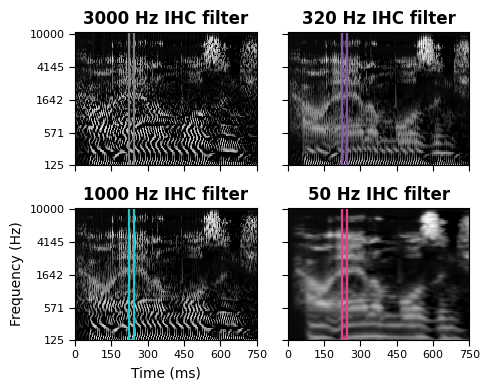

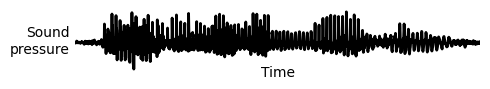

In [4]:
map_condition_to_kwargs_plot = {
    3000: {'color': '#808088', 'alpha': 1.0, 'zorder': 1, 'label': '3000 Hz'},
    1000: {'color': '#28C8C8', 'alpha': 0.45, 'zorder': 2, 'label': '1000 Hz'},
    320: {'color': '#8856a7', 'alpha': 0.30, 'zorder': 3, 'label': '320 Hz'},
    50: {'color': '#F03C8C', 'alpha': 0.15, 'zorder': 4, 'label': '50 Hz'},
}

fig, ax_arr = plt.subplots(nrows=2, ncols=2, figsize=(5, 4), sharex=True, sharey=True)
ax_arr = ax_arr.T.reshape([-1])
for itr, out_dict in enumerate(list_out_dict):
    ax = ax_arr[itr]
    nervegram = out_dict['nervegram_meanrates']
    waveform = out_dict['signal']
    sr_nervegram = out_dict['nervegram_fs']
    sr_waveform = out_dict['signal_fs']
    cfs = out_dict['cf_list']
    cutoff = out_dict['IhcLowPass_cutoff']
    tmin = 0.225
    tmax = tmin + 0.020
    str_title = '{} Hz IHC filter'.format(int(cutoff))
    color = map_condition_to_kwargs_plot[int(cutoff)]['color']
    ax = util_figures.make_nervegram_plot(
        ax,
        nervegram,
        sr=sr_nervegram,
        cfs=cfs,
        fontsize_labels=10,
        fontsize_title=12,
        fontsize_ticks=8,
        fontweight_labels=None,
        str_xlabel='Time (ms)' if itr == 1 else None,
        str_ylabel='Frequency (Hz)' if itr == 1 else None,
        str_title=str_title,
        fontweight_title='bold',
        nxticks=6,
        nyticks=5,
        interpolation='none')
    ax.add_patch(
        matplotlib.patches.Rectangle(
            (tmin * sr_nervegram, 0),
            (tmax - tmin) * sr_nervegram,
            nervegram.shape[0],
            lw=1.5,
            edgecolor='w',
            facecolor='none'))
    ax.add_patch(
        matplotlib.patches.Rectangle(
            (tmin * sr_nervegram, 0),
            (tmax - tmin) * sr_nervegram,
            nervegram.shape[0],
            lw=1.5,
            edgecolor=color,
            facecolor='none'))
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(5, 1.))
t_waveform = np.arange(len(waveform)) / sr_waveform
DECIMATE = 10
ax.plot(t_waveform[DECIMATE//2::DECIMATE], waveform[DECIMATE//2::DECIMATE], color='k', lw=2)
ax = util_figures.format_axes(
    ax,
    xlimits=[t_waveform[0], t_waveform[-1]],
    yticks=[],
    xticks=[],
    spines_to_hide=['top', 'bottom', 'right', 'left'],
)
ax.set_ylabel('Sound\npressure', rotation=0, ha='right', va='center', fontsize=10)
ax.set_xlabel('Time', rotation=0, labelpad=-5, fontsize=10)
plt.tight_layout()
plt.show()


/tmp/ipykernel_33893/1753395592.py:114: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


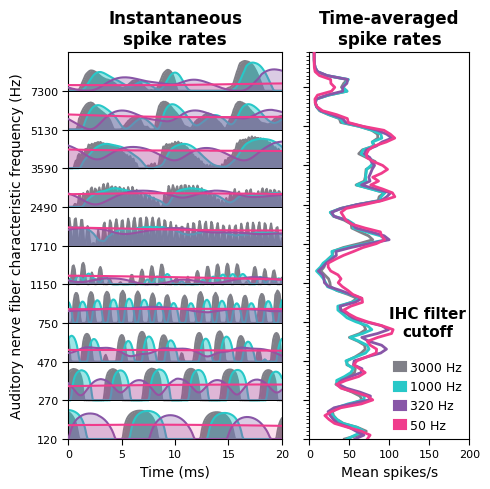

In [7]:
figsize = (5, 5)
fig, ax_arr = plt.subplots(
    figsize=figsize,
    nrows=1,
    ncols=2,
    gridspec_kw={'width_ratios': [2, 1.5]})

ax = ax_arr[0]
for dict_modification, out_dict_modified in zip(list_dict_modification, list_out_dict):
    cutoff = out_dict_modified['IhcLowPass_cutoff']
    nervegram = out_dict_modified['nervegram_meanrates']
    waveform = out_dict_modified['signal']
    sr_nervegram = out_dict_modified['nervegram_fs']
    sr_waveform = out_dict_modified['signal_fs']
    cfs = out_dict_modified['cf_list']
    t_waveform = np.arange(0, len(waveform)) / sr_waveform
    t_nervegram = np.arange(0, nervegram.shape[1]) / sr_nervegram
    TIDX = np.logical_and(t_waveform >= tmin, t_waveform <= tmax)
    ty = 1e3 * t_waveform[TIDX]
    ty = ty - ty[0]
    y = waveform[TIDX]
    TIDX = np.logical_and(t_nervegram >= tmin, t_nervegram <= tmax)
    tg = 1e3 * t_nervegram[TIDX]
    tg = tg - tg[0]
    g = nervegram[:, TIDX]
    list_ytick = []
    list_yticklabel = []
    count = 0
    offset = 200
    for itr_g in np.arange(0, g.shape[0], 10):
        baseline = offset * count
        yg = g[itr_g, :]
        color = map_condition_to_kwargs_plot[int(cutoff)]['color']
        alpha = map_condition_to_kwargs_plot[int(cutoff)]['alpha']
        zorder = map_condition_to_kwargs_plot[int(cutoff)]['zorder']
        ax.axhline(baseline, color='k', lw=0.5, zorder=10)
        ax.plot(tg, yg + baseline, color=color, lw=1.5, zorder=zorder)
        ax.fill_between(tg, g[itr_g, :] + baseline, baseline, color=color, lw=0, zorder=zorder, alpha=alpha)
        count += 1
        list_ytick.append(baseline)
        list_yticklabel.append(cfs[itr_g])
    yticks = list_ytick
    yticklabels = []
    for itr, val in enumerate(list_yticklabel):
        if 1:
            yticklabels.append(int(10 * np.round(val / 10)))
        else:
            yticklabels.append('')
ax = util_figures.format_axes(
    ax,
    xlimits=[tg[0], tg[-1]],
    ylimits=[0, baseline + max(offset, g[-1].max())],
    yticks=yticks,
    yticklabels=yticklabels,
    xticks=[0, 5, 10, 15, 20],
    fontsize_ticks=8,
    str_xlabel='Time (ms)',
    str_ylabel='Auditory nerve fiber characteristic frequency (Hz)',
    fontsize_labels=10,
    str_title='Instantaneous\nspike rates',
    fontweight_title='bold',
)
ax.set_facecolor('w')


ax = ax_arr[1]
for dict_modification, out_dict_modified in zip(list_dict_modification, list_out_dict):
    cutoff = out_dict_modified['IhcLowPass_cutoff']
    nervegram = out_dict_modified['nervegram_meanrates']
    waveform = out_dict_modified['signal']
    sr_nervegram = out_dict_modified['nervegram_fs']
    sr_waveform = out_dict_modified['signal_fs']
    cfs = out_dict_modified['cf_list']
    t_waveform = np.arange(0, len(waveform)) / sr_waveform
    t_nervegram = np.arange(0, nervegram.shape[1]) / sr_nervegram
    TIDX = np.logical_and(t_waveform >= tmin, t_waveform <= tmax)
    ty = 1e3 * t_waveform[TIDX]
    ty = ty - ty[0]
    TIDX = np.logical_and(t_nervegram >= tmin, t_nervegram <= tmax)
    g = nervegram[:, TIDX].mean(axis=1)
    yg = np.arange(len(g))
    color = map_condition_to_kwargs_plot[int(cutoff)]['color']
    zorder = map_condition_to_kwargs_plot[int(cutoff)]['zorder']
    label = map_condition_to_kwargs_plot[int(cutoff)]['label']
    ax.plot(g, yg, color=color, lw=2, zorder=zorder, label=label)
yticks = np.arange(0, g.shape[0], 10)
yticklabels = [int(10 * np.round(cfs[_] / 10)) for _ in yticks]
ax = util_figures.format_axes(
    ax,
    xlimits=[0, 200],
    ylimits=[yg[0], yg[-1]],
    yticks=yticks,
    yticks_minor=yg,
    yticklabels=[],
    xticks=[0, 50, 100, 150, 200],
    fontsize_ticks=8,
    fontsize_labels=10,
    str_xlabel='Mean spikes/s',
    str_title='Time-averaged\nspike rates',
    fontweight_title='bold',
)
ax.text(148, 34, 'IHC filter\ncutoff', ha='center', va='top', fontweight='bold', fontsize=11)
leg = ax.legend(
    frameon=False,
    framealpha=1,
    handletextpad=0.75,
    borderaxespad=0.2,
    handlelength=0.2,
    fontsize=9,
    ncol=1,
    columnspacing=0.75,
    loc='lower right',
    title_fontproperties={'size': 10, 'weight': 'bold'})
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)
ax.set_facecolor('w')

fig.patch.set_color('none')

plt.tight_layout()
plt.show()
